## **Diabetic Retinopathy Prediction**

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from tensorflow.keras import applications, optimizers
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from keras.models import load_model
from keras.preprocessing import image



import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import cv2
import os
import warnings
# import shutil
# from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score

warnings.filterwarnings("ignore")

2024-04-15 14:57:57.629201: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-15 14:57:57.697532: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-15 14:57:57.965458: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 14:57:58.899026: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
os.chdir('../../')
os.getcwd()

'/home/utpal108/dev/Upwork/Projects/Diabetic-Retinopathy-Prediction'

In [3]:
train_df = pd.read_csv('artifacts/data/train.csv')
test_df = pd.read_csv('artifacts/data/test.csv')
classes = list(train_df['diagnosis'].unique())

In [4]:
train_df.head(2)

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4


In [7]:
BATCH_SIZE = 8
EPOCHS = 20
LEARNING_RATE = 1e-4
HEIGHT = 512
WIDTH = 512
CANAL = 3
N_CLASSES = len(classes)
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [6]:
train_df['id_code'] = train_df['id_code'].apply(lambda x: x+'.png')
test_df['id_code'] = test_df['id_code'].apply(lambda x: x+'.png')
train_df['diagnosis'] = train_df['diagnosis'].astype('str')

In [7]:
# Data Generator for train, test and validation

train_datagen=ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.2,
                                 horizontal_flip=True)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="artifacts/data/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset='training')


valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="artifacts/data/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical", 
    target_size=(HEIGHT, WIDTH),
    subset='validation')


test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test_df,
        directory = "artifacts/data/test_images/",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.


Found 1928 validated image filenames.


In [8]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = ResNet50(weights='imagenet', 
                                       include_top=False,
                                       input_tensor=input_tensor)

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

In [9]:
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

In [10]:
# Freeze the weights of the InceptionNet model
for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True

In [11]:
# Complile the Model
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
metric_list = ["accuracy"]

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)
ckpt = ModelCheckpoint(filepath='model/checkpoint.model.keras', monitor='val_loss', mode='min', save_best_only=True)
callback_list = [es, rlrop, ckpt]

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=metric_list)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 518, 518,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 256, 256,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 256, 256,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 256, 256,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 258, 258,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 128, 128,  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 128, 128,  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 128, 128,  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 128, 128,  │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 128, 128,  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 128, 128,  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 128, 128,  │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 128, 128,  │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 128, 128,  │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 128, 128,  │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 128, 128,  │      1,024 │ conv2_block1_3_c

 Total params: 27,794,309 (106.03 MB)

 Trainable params: 4,206,597 (16.05 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [12]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size


history = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=EPOCHS,
    callbacks=callback_list,
    verbose=1
).history


Epoch 1/20


2024-04-15 00:40:24.259483: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.
2024-04-15 00:40:24.400185: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 136323072 exceeds 10% of free system memory.
2024-04-15 00:40:24.487220: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.
2024-04-15 00:40:24.644972: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.
2024-04-15 00:40:24.902810: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.


366/366 ━━━━━━━━━━━━━━━━━━━━ 1043s 3s/step - accuracy: 0.3628 - loss: 2.3978 - val_accuracy: 0.4588 - val_loss: 1.3833 - learning_rate: 1.0000e-04
Epoch 2/20
  1/366 ━━━━━━━━━━━━━━━━━━━━ 12:51 2s/step - accuracy: 0.3750 - loss: 2.2216

2024-04-15 00:57:40.005946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-15 00:57:41.001125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


366/366 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.3750 - loss: 2.2216 - val_accuracy: 0.7500 - val_loss: 1.0894 - learning_rate: 1.0000e-04
Epoch 3/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 1447s 4s/step - accuracy: 0.3801 - loss: 1.8969 - val_accuracy: 0.4602 - val_loss: 1.3333 - learning_rate: 1.0000e-04
Epoch 4/20
  1/366 ━━━━━━━━━━━━━━━━━━━━ 1:01:36 10s/step - accuracy: 0.3750 - loss: 1.0594

2024-04-15 01:22:01.581947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


366/366 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.3750 - loss: 1.0594 - val_accuracy: 0.5000 - val_loss: 1.1948 - learning_rate: 1.0000e-04
Epoch 5/20


2024-04-15 01:22:06.950826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-15 01:22:20.039717: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-04-15 01:22:31.968740: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-04-15 01:22:48.355985: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-04-15 01:22:56.467275: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3960 - loss: 1.6798
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
366/366 ━━━━━━━━━━━━━━━━━━━━ 2128s 6s/step - accuracy: 0.3960 - loss: 1.6797 - val_accuracy: 0.4602 - val_loss: 1.3141 - learning_rate: 1.0000e-04
Epoch 6/20
  1/366 ━━━━━━━━━━━━━━━━━━━━ 52:30 9s/step - accuracy: 0.3750 - loss: 1.5414

2024-04-15 01:57:44.133221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-15 01:57:48.362488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


366/366 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.3750 - loss: 1.5414 - val_accuracy: 0.5000 - val_loss: 1.3934 - learning_rate: 5.0000e-05
Epoch 7/20


2024-04-15 01:58:00.312673: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-04-15 01:58:19.453475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6 of 8
2024-04-15 01:58:28.771746: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


366/366 ━━━━━━━━━━━━━━━━━━━━ 2224s 6s/step - accuracy: 0.4303 - loss: 1.4825 - val_accuracy: 0.4615 - val_loss: 1.3599 - learning_rate: 5.0000e-05
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


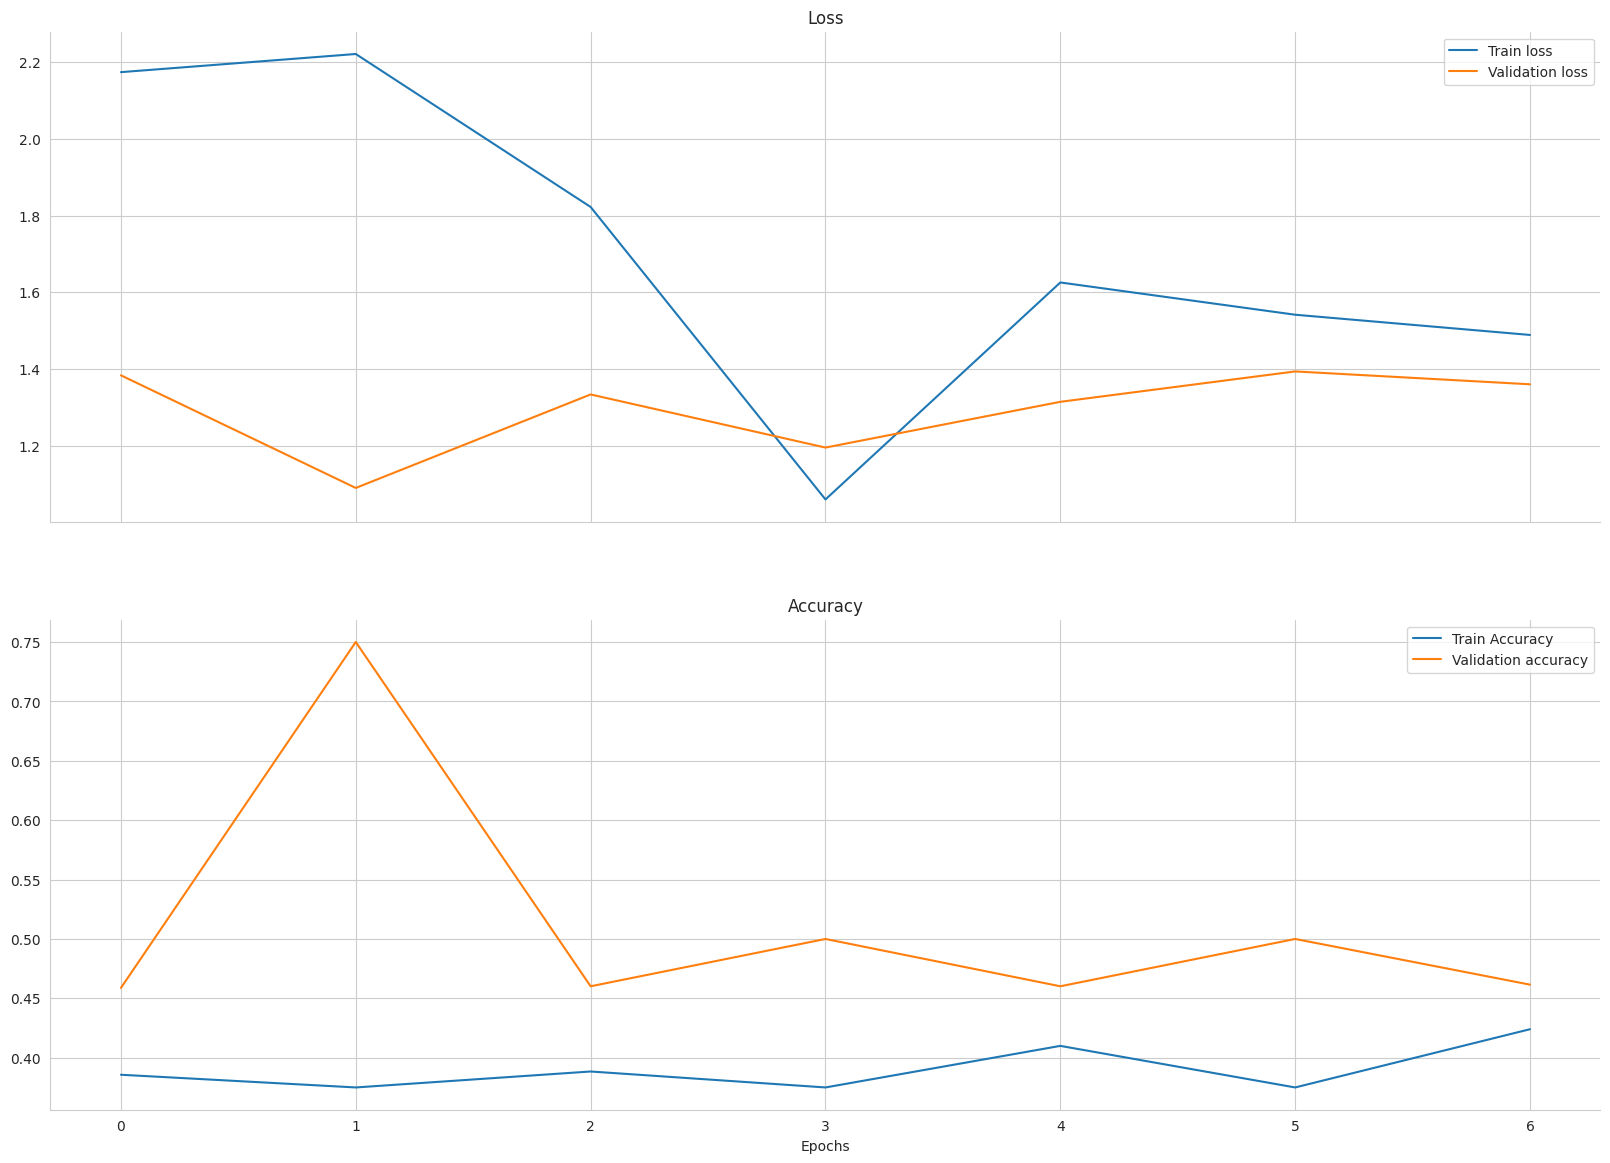

In [13]:
# Model loss graph
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['accuracy'], label='Train Accuracy')
ax2.plot(history['val_accuracy'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()


In [14]:
# Model Evaluation
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(  
        dataframe=train_df,
        directory = "artifacts/data/train_images/",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds = model.predict(complete_generator, steps=STEP_SIZE_COMPLETE)
train_preds = [np.argmax(pred) for pred in train_preds]

Found 3662 validated image filenames.


3662/3662 ━━━━━━━━━━━━━━━━━━━━ 2059s 562ms/step


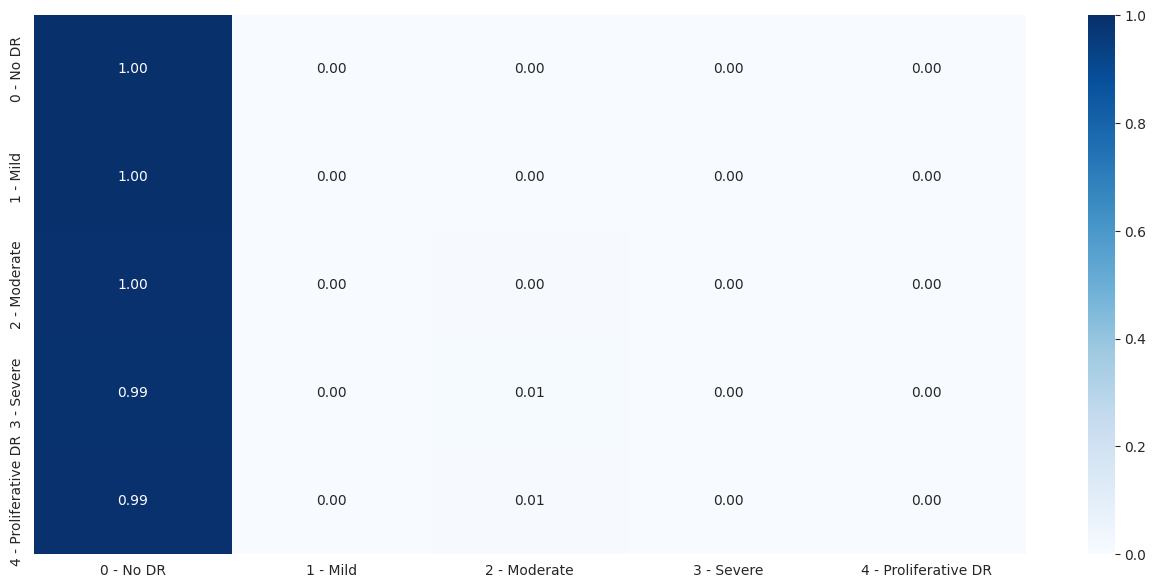

In [15]:
# Confusion Matrix
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(train_df['diagnosis'].astype('int'), train_preds)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

In [16]:
# Finding the Quadratic Kappa Score
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, train_df['diagnosis'].astype('int'), weights='quadratic'))

Train Cohen Kappa score: 0.005


In [17]:
# Save the model
model.save('artifacts/model/diabetic_retinopathy_model.h5')

In [3]:
# Load the saved model
loaded_model = load_model('artifacts/training/dr_detection_model.h5')

In [4]:
# Path to the test image you want to predict
test_image_path = "artifacts/data/train_images/000c1434d8d7.png"

In [8]:
# Load and preprocess the test image
img = image.load_img(test_image_path, target_size=(HEIGHT, WIDTH))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

In [9]:
# Make predictions
predictions = loaded_model.predict(img_array)
predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[1.1902983e-07, 1.4249976e-02, 9.8529184e-01, 1.0529320e-05,
        4.4751615e-04]], dtype=float32)

In [10]:
# Convert predictions to the corresponding class
predicted_class = np.argmax(predictions)
print("Predicted Diabetic Retinopathy Stage:", predicted_class)

Predicted Diabetic Retinopathy Stage: 2
